In [32]:
%matplotlib notebook

import numpy as np
from skimage import io, filters
import os
import glob

<IPython.core.display.Javascript object>


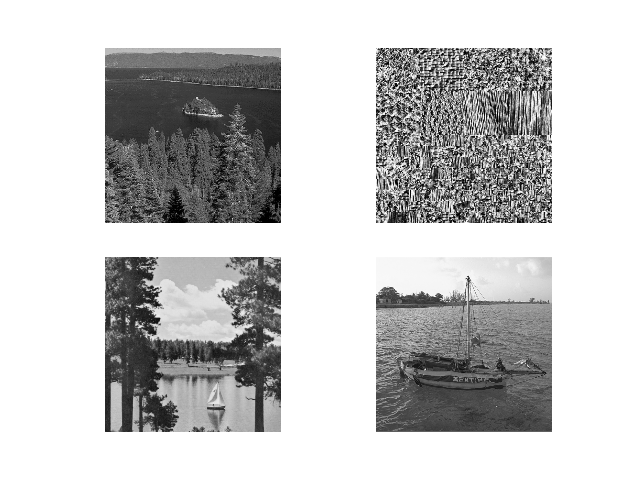

In [33]:
if __name__ == '__main__':
    path = 'Images/Q3'
    fig = plt.figure()
    count = 1
    for filename in glob.glob(os.path.join(path, '*.bmp')): 
        a = fig.add_subplot(2, 2, count)
        im = plt.imread(filename)
        imgplot = plt.imshow(im, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        plt.axis('off')
        count += 1

In [87]:
if __name__ == '__main__':
    path = 'Images/Q3'
#     fig = plt.figure()
    count = 1
    for filename in glob.glob(os.path.join(path, '*.bmp')): 
        a = fig.add_subplot(2, 2, count)
        im = plt.imread(filename)
#         print im
        s_h = filters.sobel_h(im)
#         print 'Mx'
#         print s_h
        s_v = filters.sobel_v(im)
#         print 'My'
#         print s_v
        mag = np.sqrt(s_h**2 + s_v**2)
#         print 'M'
#         print mag
        direc = np.arctan2(s_v, s_h)
#         print 'Theta'
#         print direc
        scaled_dir = np.copy(direc)
        # rounding
        eighth = 2*np.pi/8
        scaled_dir = np.round(scaled_dir/eighth)*eighth
        # account for cyclical -- -pi to pi
        scaled_dir[scaled_dir == -np.pi] = np.pi
        
#         imgplot = plt.imshow(s_h.astype('uint8'), cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
#         imgplot = plt.imshow(s_v.astype('uint8'), cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
#         plt.axis('off')
        count += 1

[]
[]
[]
[]
